# Aspectos prácticos para la carga de datos masivos.




## Etapa 1: Carga de los datos

In [7]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import os, shutil


In [21]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [13]:
import opendatasets as od
od.download('https://www.kaggle.com/c/dogs-vs-cats')


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


100%|██████████| 812M/812M [00:29<00:00, 28.7MB/s] 



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


In [17]:
!unzip ./content/dogs-vs-cats/test1.zip

Archive:  ./content/dogs-vs-cats/test1.zip
   creating: test1/
  inflating: test1/1.jpg             
  inflating: test1/10.jpg            
  inflating: test1/100.jpg           
  inflating: test1/1000.jpg          
  inflating: test1/10000.jpg         
  inflating: test1/10001.jpg         
  inflating: test1/10002.jpg         
  inflating: test1/10003.jpg         
  inflating: test1/10004.jpg         
  inflating: test1/10005.jpg         
  inflating: test1/10006.jpg         
  inflating: test1/10007.jpg         
  inflating: test1/10008.jpg         
  inflating: test1/10009.jpg         
  inflating: test1/1001.jpg          
  inflating: test1/10010.jpg         
  inflating: test1/10011.jpg         
  inflating: test1/10012.jpg         
  inflating: test1/10013.jpg         
  inflating: test1/10014.jpg         
  inflating: test1/10015.jpg         
  inflating: test1/10016.jpg         
  inflating: test1/10017.jpg         
  inflating: test1/10018.jpg         
  inflating: test1/10019.

In [15]:
# Se decomprime la carpeta zip
!unzip ./content/dogs-vs-cats/train.zip

Archive:  ./content/dogs-vs-cats/train.zip
   creating: train/
  inflating: train/cat.0.jpg         
  inflating: train/cat.1.jpg         
  inflating: train/cat.10.jpg        
  inflating: train/cat.100.jpg       
  inflating: train/cat.1000.jpg      
  inflating: train/cat.10000.jpg     
  inflating: train/cat.10001.jpg     
  inflating: train/cat.10002.jpg     
  inflating: train/cat.10003.jpg     
  inflating: train/cat.10004.jpg     
  inflating: train/cat.10005.jpg     
  inflating: train/cat.10006.jpg     
  inflating: train/cat.10007.jpg     
  inflating: train/cat.10008.jpg     
  inflating: train/cat.10009.jpg     
  inflating: train/cat.1001.jpg      
  inflating: train/cat.10010.jpg     
  inflating: train/cat.10011.jpg     
  inflating: train/cat.10012.jpg     
  inflating: train/cat.10013.jpg     
  inflating: train/cat.10014.jpg     
  inflating: train/cat.10015.jpg     
  inflating: train/cat.10016.jpg     
  inflating: train/cat.10017.jpg     
  inflating: train/cat.10

In [12]:
original_dataset_dir = './content/train'
base_dir = './content'
# Se crea un directorio para el entrenamiento
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# Se crea un directorio para el test
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# Dentro de la carpeta de entrenamiento se geneta una carpeta para cada clase.
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Dentro de la carpeta de prueba se geneta una carpeta para cada clase.
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [13]:
# Se copian 7000 imágenes de gatos en la carpeta de entrenamiento
fnames = ['cat.{}.jpg'.format(i) for i in range(7000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

In [14]:
# Se copian 7000 imágenes de perros en la carpeta de entrenamiento
fnames = ['dog.{}.jpg'.format(i) for i in range(7000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [15]:
# Se copian 3000 imágenes de gatos en la carpeta de prueba
fnames = ['cat.{}.jpg'.format(i) for i in range(7000, 10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

In [16]:
# Se copian 3000 imágenes de perros en la carpeta de prueba
fnames = ['dog.{}.jpg'.format(i) for i in range(7000, 10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

## Etapa 2: Procesamiento de los datos

Ahora deben ser cargadas las imágenes a través del módulo ImageDataGenerator

In [17]:
# Se fija el tamaño de las imágenes.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Se escribe una rutina para transformar las imágenes
data_transform = transforms.Compose([
    # Se hace un reescalado de las imágenes dado que tienen tamaños diferentes
    transforms.Resize(size=IMAGE_SIZE),
    # Se hace DataAugmentation al generar imágenes sintéticas que corresponden a
    # versiones rotadas de las imágenes originales.
    transforms.RandomRotation(degrees=45),
    # DataAugmentation: Se realiza un flip horixontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Se convierten las imágenes a tensores
    transforms.ToTensor()
])

# No se suele realizar DataAugmentation en el conjunto de test
data_transform_test = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

In [18]:
# Se crean los conuntos de train y test.
train_data = datasets.ImageFolder(root=train_dir, # Se pasa la dirección donde
                                  # se gurdan las imágenes de train.
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform_test)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 14000
    Root location: ./content/train_dir
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 6000
    Root location: ./content/test_dir
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [19]:
len(train_data)



14000

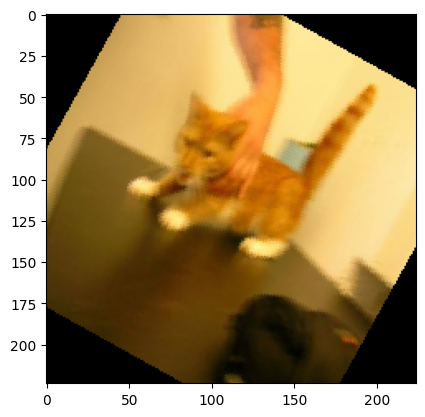

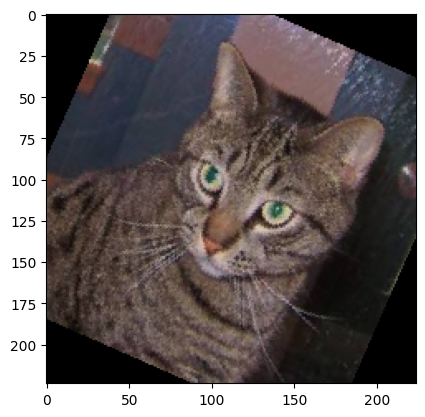

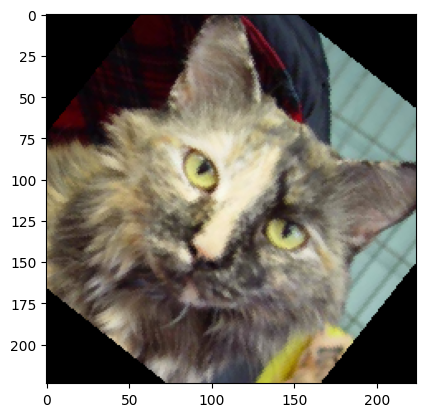

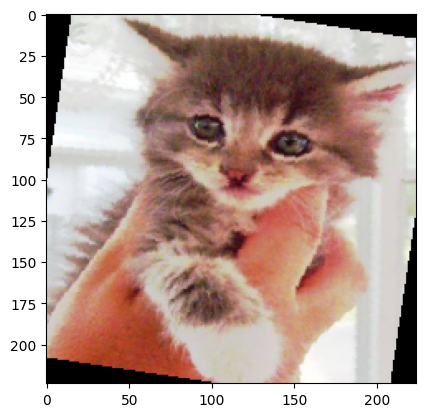

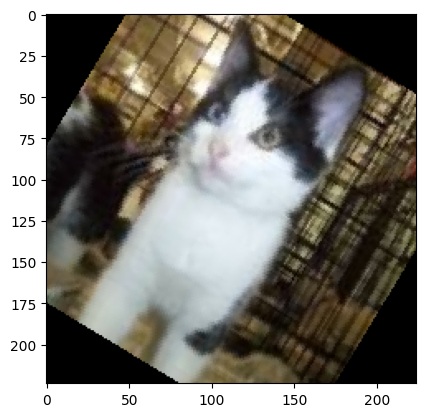

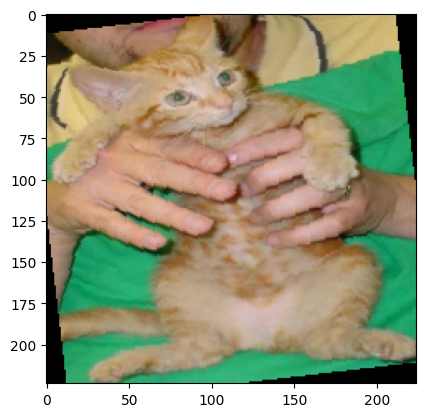

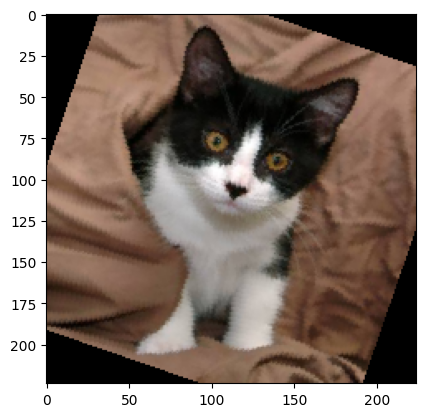

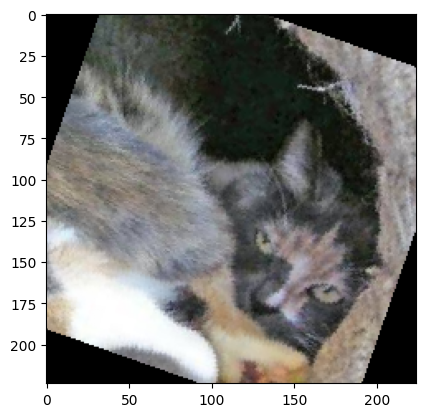

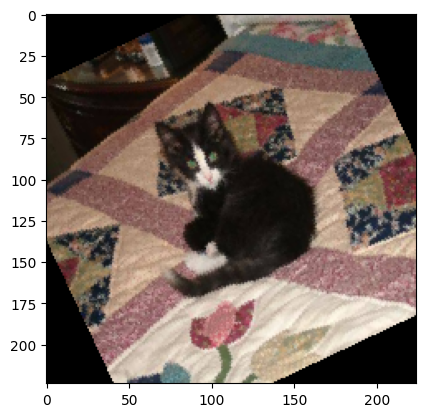

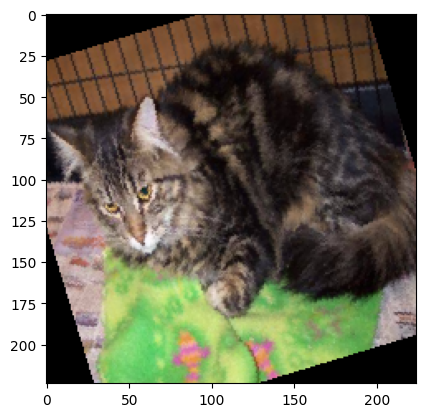

In [20]:
# Se visualizan algunas imágenes generadas en el DataAugmentation.
aux = 0
for img, label in train_data:
  aux += 1
  plt.imshow(img.permute(1, 2, 0))
  plt.show()
  if aux == 10:
    break

In [21]:
# Se rectifican las etiquetas
class_names = train_data.classes
print("Class names: ",class_names)


class_dict = train_data.class_to_idx
print("Class names as a dict: ",class_dict)

# Se verifican las longitudes
print("The lengths of the training and test sets: ", len(train_data), len(test_data))

Class names:  ['cats', 'dogs']
Class names as a dict:  {'cats': 0, 'dogs': 1}
The lengths of the training and test sets:  14000 6000


In [22]:
# know how many cpu counts have the gpu
print(torch.mps.get_device_name(0))


AttributeError: module 'torch.mps' has no attribute 'get_device_name'

In [23]:
from torch.utils.data import DataLoader

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = 1 if torch.backends.mps.is_available() else os.cpu_count()

# DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=NUM_WORKERS,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x14fd0f250>,
 <torch.utils.data.dataloader.DataLoader at 0x14fd0f970>)

In [24]:
NUM_WORKERS

1

## Etapa 3: Definición del modelo por transferencia del aprendizaje


In [25]:
# Se verifica la disponibilidad de la GPU
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
#device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

print(device)


mps


In [47]:
# Se carga el modelo pre-entrenado.
model = models.vgg16(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [48]:
device

device(type='mps')

In [49]:
# Se modifica la última capa para que tenga, únicamente 1 neurona
model.classifier[6] = nn.Linear(in_features=4096, out_features=1)
# Se agrega una activación Sigmoid a la última capa
model.classifier.append(nn.Sigmoid())

model = model.to(device)

loss_fn = nn.BCELoss()
epochs = 5

optimizer = torch.optim.SGD(model.to(device).parameters(), lr=0.001)


In [50]:
# Para visualizar el modelo

!pip install torchinfo
import torchinfo

from torchinfo import summary

1337.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [51]:
summary(model, input_size=[1, 3, IMAGE_WIDTH ,IMAGE_HEIGHT])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [52]:
# The optimization loop.

loss_tr = []
loss_te = []
for epoch in range(epochs):
  for x, y in train_dataloader:
    print("hola 1")
    # The variable should be sent to the GPU
    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)
    print("hola 2")
    # Make predictions
    model.train()
    print("hola 3")
    y_pred = model(x)
    print("hola 4")
    y = y.unsqueeze(1).to(torch.float32)
    print("hola 5")
    # print(y,y_pred)
    # Compute the loss of current predictions
    loss = loss_fn(y_pred, y)
    print("hola 6")
    # Clean the gradients
    optimizer.zero_grad()
    print("hola 7")
    # Perform backpropagation
    loss.backward()
    print("hola 8")
    # update weights
    optimizer.step()
    print("hola 9")
    # Storing the training and test losses
    loss_tr.append(loss.item())
    print("hola 10")
    loss_test = 0
    print("hola 11")
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32).unsqueeze(1)        
        # calculate outputs by running images through the network
        outputs = model(images)
        loss_test += loss_fn(outputs, labels).item() * labels.size(0)

  loss_te.append(loss_test/len(test_dataloader.dataset))
  print("epoch {} loss: {:.4f} test_loss: {:.4f}".format(epoch + 1,loss.item(),loss_test/len(test_dataloader.dataset)))

KeyboardInterrupt: 

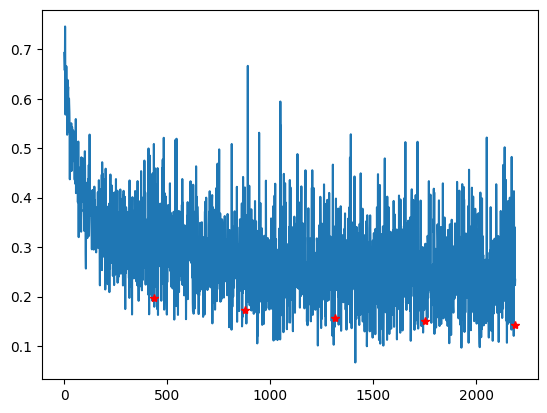

In [ ]:
# Plot the losses for the train and test sets
import numpy as np
plt.plot(loss_tr)
plt.plot(np.arange(1,5+1)*len(train_dataloader.dataset)//32,loss_te, 'r*')
plt.show()

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.round(outputs.data)
        total += labels.size(0)
        correct += (torch.flatten(predicted) == labels).sum().item()
        # print(correct, total)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 94 %
